# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

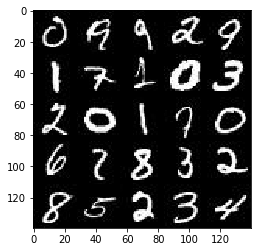

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

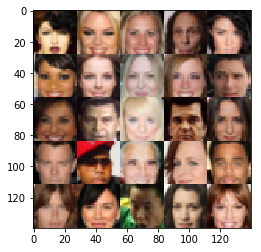

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        alpha=0.2        
        
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):

        x1 = tf.layers.dense(z,  7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate,is_train:False})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 2.0234
Epoch 1/2... Discriminator Loss: 0.1280... Generator Loss: 5.7141
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 1.3610
Epoch 1/2... Discriminator Loss: 2.7940... Generator Loss: 0.0943
Epoch 1/2... Discriminator Loss: 2.0381... Generator Loss: 0.5410
Epoch 1/2... Discriminator Loss: 1.8746... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.5253... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 2.1604... Generator Loss: 0.1782
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 1.0277


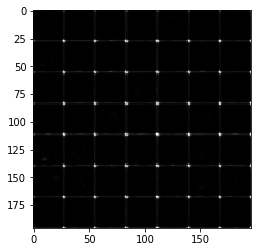

Epoch 1/2... Discriminator Loss: 1.7455... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.2906
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.7970... Generator Loss: 0.2778
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.9014... Generator Loss: 0.2179
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 1.2604
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.9102


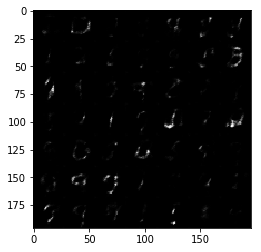

Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.5031
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 1.6904... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.2789
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.4279
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.4684... Generator Loss: 0.3890


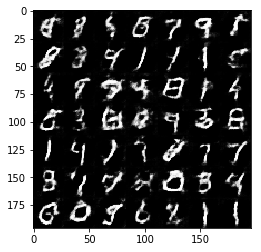

Epoch 1/2... Discriminator Loss: 1.9123... Generator Loss: 0.2379
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.8523... Generator Loss: 0.2188
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.5333... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.8790


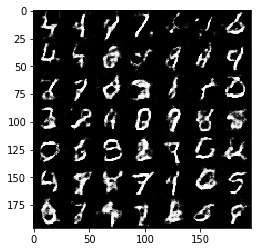

Epoch 1/2... Discriminator Loss: 1.7226... Generator Loss: 0.2585
Epoch 1/2... Discriminator Loss: 1.9538... Generator Loss: 0.2007
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 1.6323... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 1.6055... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.5325
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.4028
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.5081... Generator Loss: 0.3875


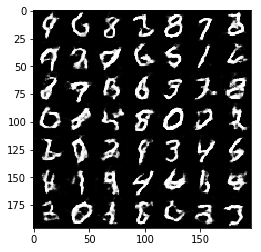

Epoch 1/2... Discriminator Loss: 1.5198... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 1.1488
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.6257... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 0.2349
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.7385... Generator Loss: 1.3877


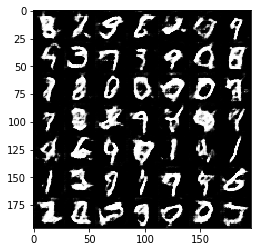

Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.3979
Epoch 1/2... Discriminator Loss: 2.1880... Generator Loss: 0.1582
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.6907... Generator Loss: 0.2865
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 1.2295
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.5866
Epoch 1/2... Discriminator Loss: 2.7748... Generator Loss: 0.0874
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.5395


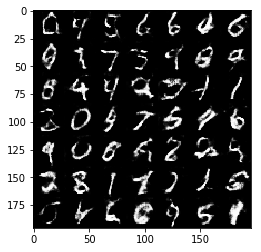

Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.9372
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.8514
Epoch 1/2... Discriminator Loss: 1.3591... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 1.3454... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.3609
Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.8854... Generator Loss: 0.2066
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.6903
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.4124


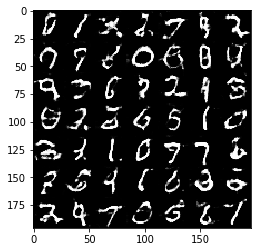

Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.8985
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 2.2598... Generator Loss: 0.1422
Epoch 1/2... Discriminator Loss: 1.7651... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.3498
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 1.0185
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.5384


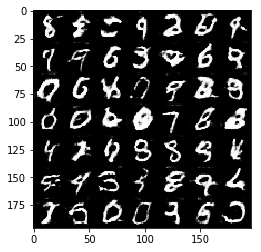

Epoch 1/2... Discriminator Loss: 2.3238... Generator Loss: 1.5103
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.2931
Epoch 2/2... Discriminator Loss: 1.8173... Generator Loss: 1.4551
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.4154... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.3298... Generator Loss: 0.4781
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.5991... Generator Loss: 0.2981
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.8602


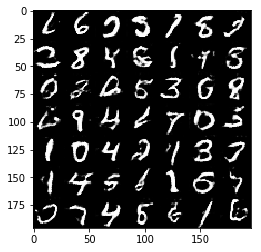

Epoch 2/2... Discriminator Loss: 1.6014... Generator Loss: 1.6129
Epoch 2/2... Discriminator Loss: 1.5998... Generator Loss: 0.3233
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.5733
Epoch 2/2... Discriminator Loss: 1.8091... Generator Loss: 0.2445
Epoch 2/2... Discriminator Loss: 1.7461... Generator Loss: 0.2645
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.2870
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.4813... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 2.0745... Generator Loss: 0.1649


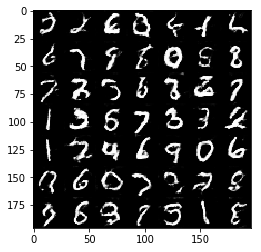

Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 1.1491
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.5900
Epoch 2/2... Discriminator Loss: 1.3555... Generator Loss: 0.5128
Epoch 2/2... Discriminator Loss: 1.8832... Generator Loss: 0.2129
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 2.3596
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.4205
Epoch 2/2... Discriminator Loss: 1.5868... Generator Loss: 1.0429


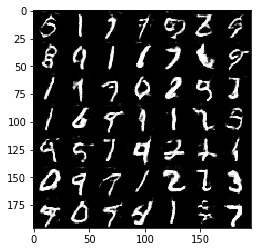

Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.4115
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.7588... Generator Loss: 0.2614
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.7190... Generator Loss: 1.9002
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.3470
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.5973


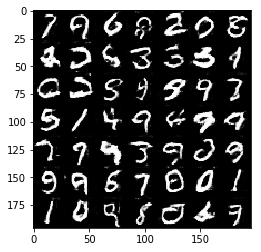

Epoch 2/2... Discriminator Loss: 2.0071... Generator Loss: 0.1931
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.6127... Generator Loss: 0.3437
Epoch 2/2... Discriminator Loss: 2.1028... Generator Loss: 0.1783
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.4837... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.4138


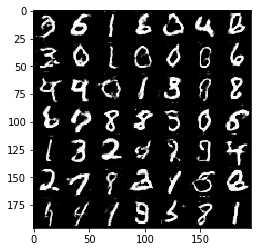

Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 0.9452
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.4214... Generator Loss: 2.3093
Epoch 2/2... Discriminator Loss: 1.6734... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 2.1329... Generator Loss: 0.1738
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 2.0011... Generator Loss: 0.2227


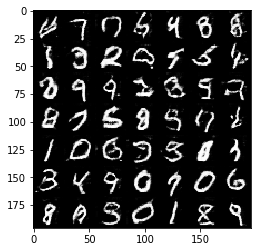

Epoch 2/2... Discriminator Loss: 1.5825... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 1.1674... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.7812... Generator Loss: 0.2454
Epoch 2/2... Discriminator Loss: 1.4787... Generator Loss: 1.6798
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.6084
Epoch 2/2... Discriminator Loss: 1.5515... Generator Loss: 0.3428
Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.3677
Epoch 2/2... Discriminator Loss: 1.6699... Generator Loss: 0.2771
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.7611... Generator Loss: 0.2869


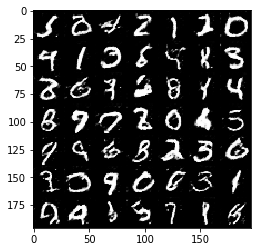

Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.4740
Epoch 2/2... Discriminator Loss: 2.2757... Generator Loss: 0.1358
Epoch 2/2... Discriminator Loss: 0.5729... Generator Loss: 1.6294
Epoch 2/2... Discriminator Loss: 2.3578... Generator Loss: 0.1307
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 1.3827
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.6749
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 1.1389


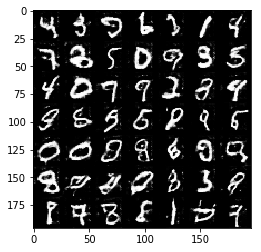

Epoch 2/2... Discriminator Loss: 1.0506... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 1.6057... Generator Loss: 1.6100
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.9429
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 1.2391
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 1.6738... Generator Loss: 0.3534
Epoch 2/2... Discriminator Loss: 1.2596... Generator Loss: 0.9531


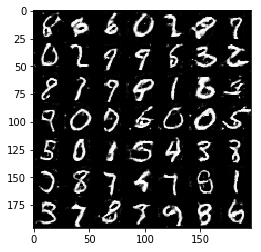

Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 1.0086
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.4692
Epoch 2/2... Discriminator Loss: 2.1401... Generator Loss: 0.1854
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 0.5115... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.4860


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 6.1300
Epoch 1/1... Discriminator Loss: 5.2645... Generator Loss: 0.0666
Epoch 1/1... Discriminator Loss: 2.5411... Generator Loss: 1.5819
Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 3.8850
Epoch 1/1... Discriminator Loss: 0.2836... Generator Loss: 2.3874
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.9741
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 3.6076
Epoch 1/1... Discriminator Loss: 2.3160... Generator Loss: 0.2562


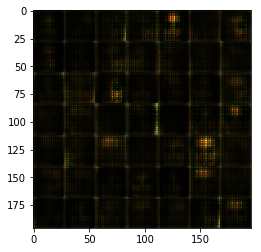

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 3.9884
Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 2.0163... Generator Loss: 0.2229
Epoch 1/1... Discriminator Loss: 1.6911... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.8674... Generator Loss: 0.2842


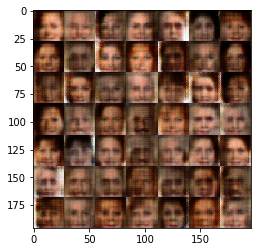

Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.7200... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.0005


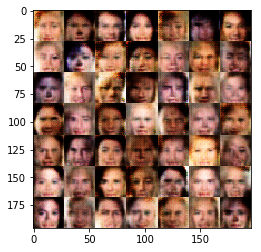

Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.7843... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 0.4082


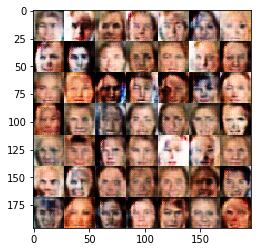

Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.8354... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.5529


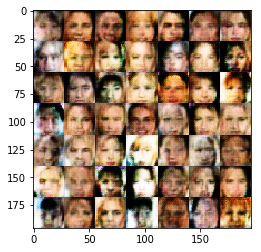

Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.7283... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6557


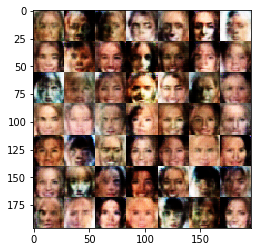

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.9280... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.6672


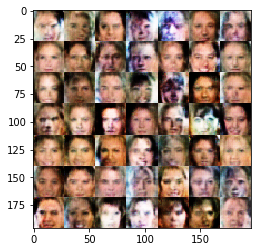

Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.6219


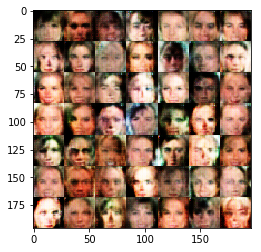

Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.5536


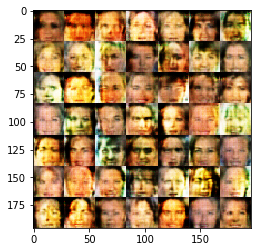

Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.6066... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6003


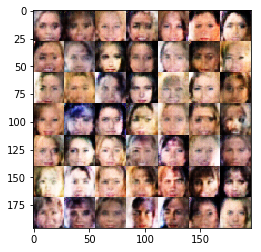

Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.7693


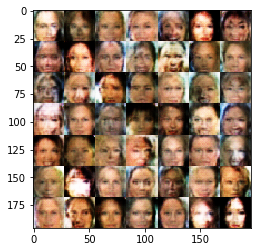

Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7248


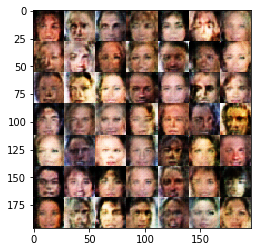

Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5709


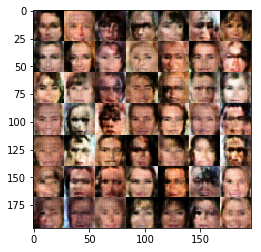

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.6739


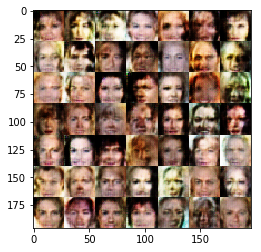

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7235


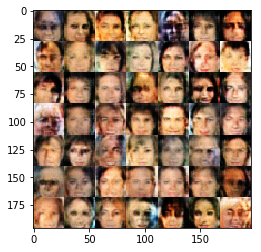

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8962


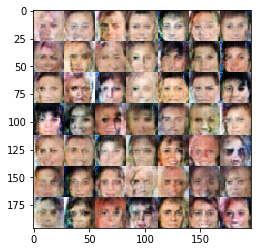

Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.4903


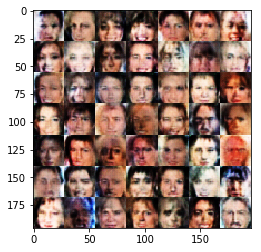

Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5778


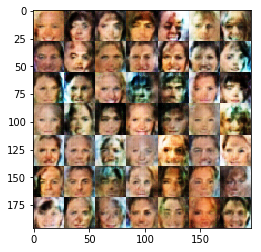

Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7358


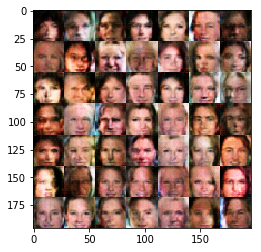

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6948


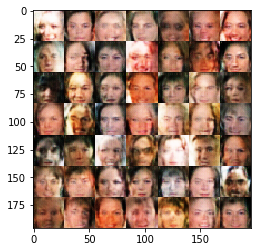

Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6260


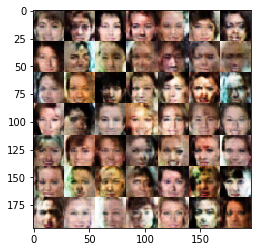

Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6197


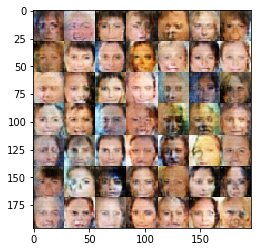

Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6719


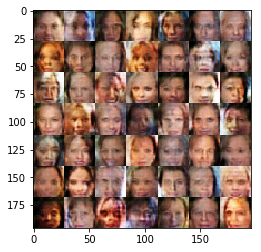

Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6903


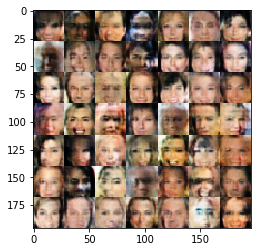

Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6536


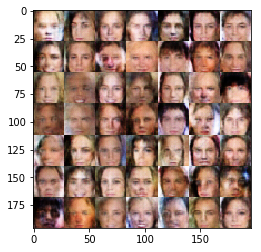

Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7543


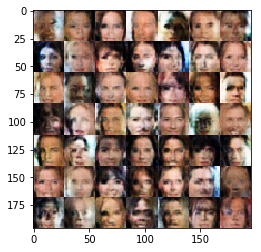

Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5060
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6237


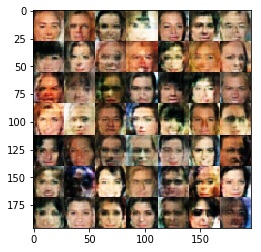

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5658


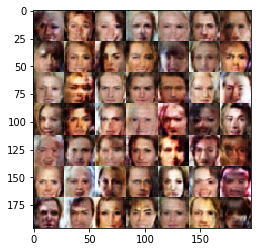

Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.5385


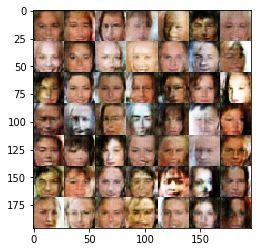

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6043


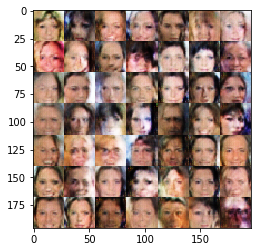

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7701


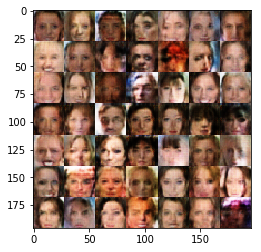

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6380


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.